# Category 3

Convolution Neural Network (합성곱 신경망)를 활용한 이미지 분류 (Image Classification)

For this task you will build a classifier for Rock-Paper-Scissors 
based on the rps dataset.

IMPORTANT: Your final layer should be as shown, do not change the
provided code, or the tests may fail

IMPORTANT: Images will be tested as 150x150 with 3 bytes of color depth
So ensure that your input layer is designed accordingly, or the tests
may fail. 

NOTE THAT THIS IS UNLABELLED DATA. 
You can use the ImageDataGenerator to automatically label it
and we have provided some starter code.

-------------------------------

이 작업에서는 Rock-Paper-Scissors에 대한 분류기를 작성합니다.
rps 데이터 셋을 기반으로합니다.

중요 : 최종 레이어는 그림과 같아야합니다.

중요 : 이미지는 3 바이트 150x150의 컬러사진으로 테스트됩니다.
따라서 입력 레이어가 그에 따라 설계되었거나 테스트되었는지 확인하십시오.

ImageDataGenerator를 사용하여 자동으로 레이블을 지정할 수 있습니다.

# import


In [1]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Load Dataset

가위바위보에 대한 손의 사진을 가지고 `가위`인지, `바위`인지, `보자기`인지 분류하는 `classification` 문제

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

# Preprocessing : ImageDataGenerator

데이터셋 경로

In [3]:
TRAINING_DIR = 'tmp/rps/'

`ImageDataGenerator`를 정의합니다.

다음의 옵션 값들로 Image Aumentation(이미지 변형) 옵션을 적절히 조절해 주세요

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

In [4]:
training_datagen = ImageDataGenerator(
    rescale= 1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.2
)

# Make Generator

ImageDataGenerator를 잘 만들어 주었다면, `flow_from_directory`로 이미지를 어떻게 공급해 줄 것인가를 지정해 주어야합니다.

* train / validation set 전용 generator를 별도로 정의합니다.
* `batch_size`를 정의합니다 (128)
* `target_size`를 정의합니다. (150 x 150). 이미지를 알아서 타겟 사이즈 만큼 잘라내어 공급합니다.
* `class_mode`는 3개 이상의 클래스인 경우 'categorical' 이진 분류의 경우 `binary`를 지정합니다.
* `subset`을 지정합니다. (training / validation)


In [5]:


training_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                          batch_size=128,
                                                          target_size=(150, 150),
                                                          class_mode='categorical',
                                                          subset='training'
                                                          )

Found 2016 images belonging to 3 classes.


In [6]:
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                            batch_size=128,
                                                            target_size=(150, 150),
                                                            class_mode='categorical',
                                                            subset='validation')

Found 504 images belonging to 3 classes.


# 시각화

원본
Found 2520 images belonging to 3 classes.
(128, 150, 150, 3) (128, 3)
[1. 0. 0.]


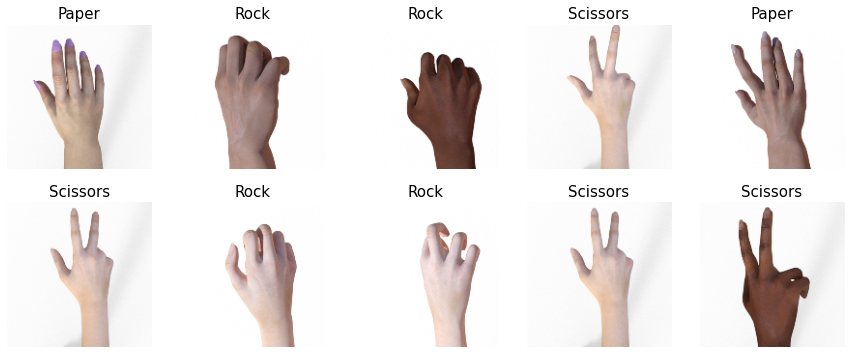

Augmentation 적용한 사진 파일
(128, 150, 150, 3) (128, 3)
[1. 0. 0.]


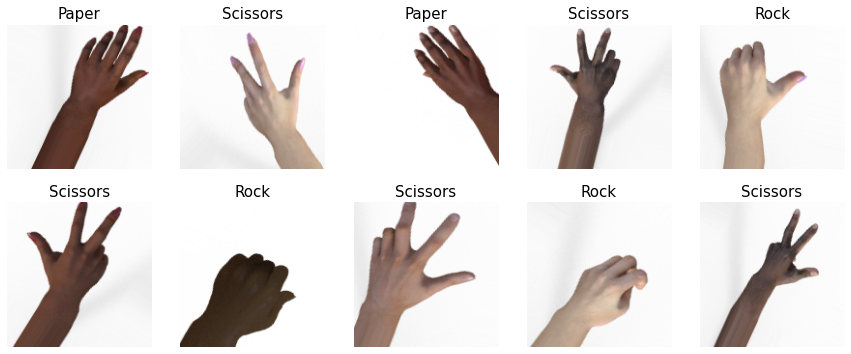

In [8]:
import matplotlib.pyplot as plt

class_map = {
    0: 'Paper',
    1: 'Rock',
    2: 'Scissors'
}

print('원본')

original_datagen = ImageDataGenerator(rescale = 1./255)
original_generator = original_datagen.flow_from_directory(TRAINING_DIR,
                                                          batch_size=128,
                                                          target_size=(150, 150),
                                                          class_mode='categorical')

for x, y in original_generator:
  print(x.shape, y.shape)
  print(y[0])

  fig, axes = plt.subplots(2, 5)
  fig.set_size_inches(15, 6)
  for i in range(10):
    axes[i//5, i%5].imshow(x[i])
    axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
    axes[i//5, i%5].axis('off')
  plt.show()
  break

print('Augmentation 적용한 사진 파일')

for x, y in training_generator:
  print(x.shape, y.shape)
  print(y[0])

  fig, axes = plt.subplots(2, 5)
  fig.set_size_inches(15,6)
  for i in range(10):
    axes[i//5, i%5].imshow(x[i])
    axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
    axes[i//5, i%5].axis('off')

  plt.show()
  break

## Convolution Neural Network (CNN)

**CNN - activation - Pooling** 과정을 통해 이미지 부분 부분의 **주요한 Feature 들을 추출**해 냅니다.

CNN을 통해 우리는 다양한 1개의 이미지를 `filter`를 거친 다수의 이미지로 출력합니다.

`filter`의 사이즈는 **3 X 3 필터**를 자주 사용합니다

또한, 3 X 3 필터를 거친 이미지의 사이즈는 **2px 만큼 사이즈가 줄어듭니다**.

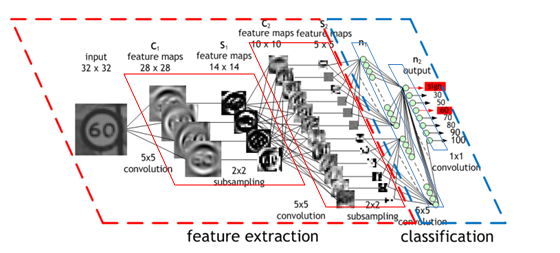

In [9]:
Image('https://devblogs.nvidia.com/wp-content/uploads/2015/11/fig1.png', width=800)

## 이미지 특성 추출: Conv2D

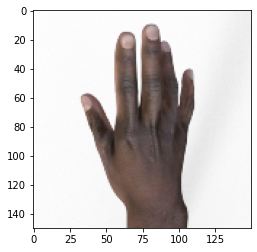

In [15]:
for x, y in original_generator:
  pic = x[:5]
  break

plt.imshow(plc[0])

In [14]:
conv2d = Conv2D(64, (3,3), input_shape=(150, 150, 3))
conv2d_activation = Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3))

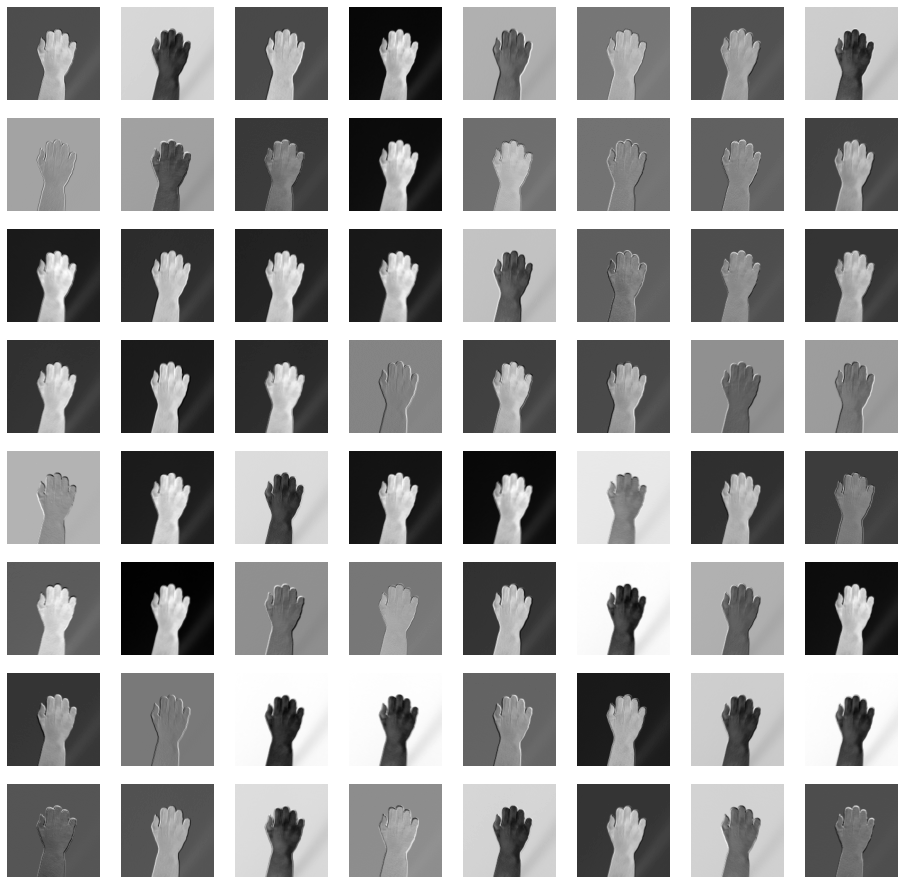

In [16]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16,16)
for i in range(64):
  axes[i//8, i%8].imshow(conv2d(pic)[0, :,:,i], cmap='gray')
  axes[i//8, i%8].axis('off')

## 이미지 특성 추출: MaxPooling2D

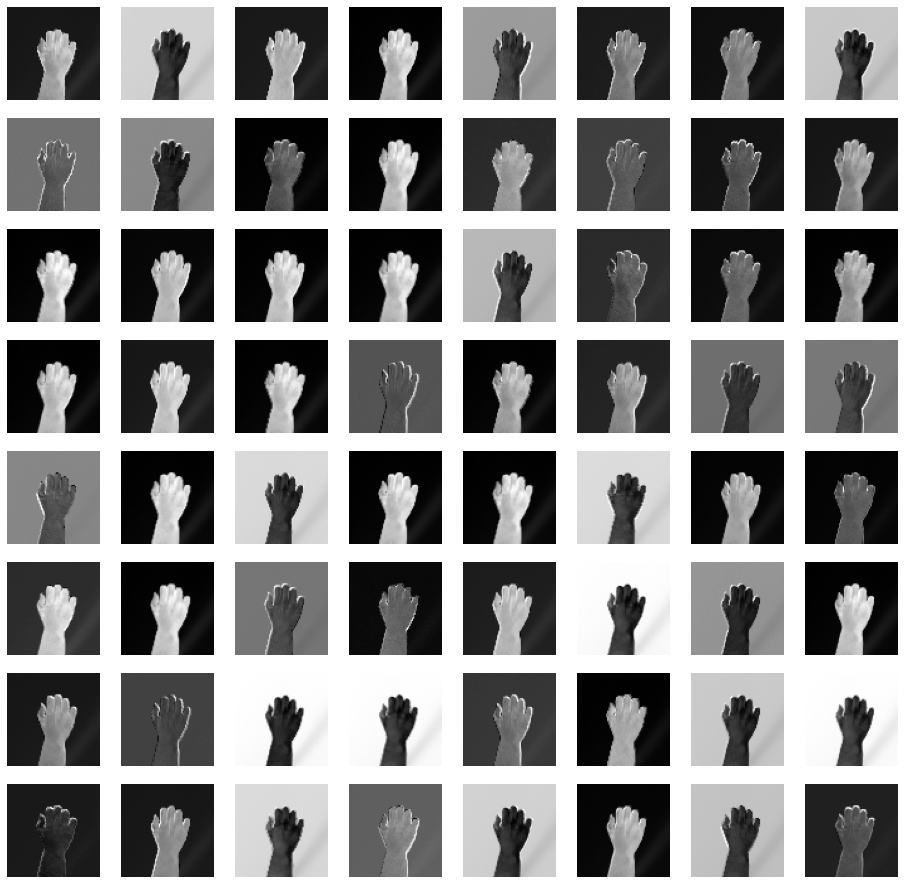

In [17]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16, 16)
for i in range(64):
  axes[i//8, i%8].imshow(MaxPooling2D(2, 2)(conv2d(pic))[0, :, :, i], cmap='gray')
  axes[i//8, i%8].axis('off')

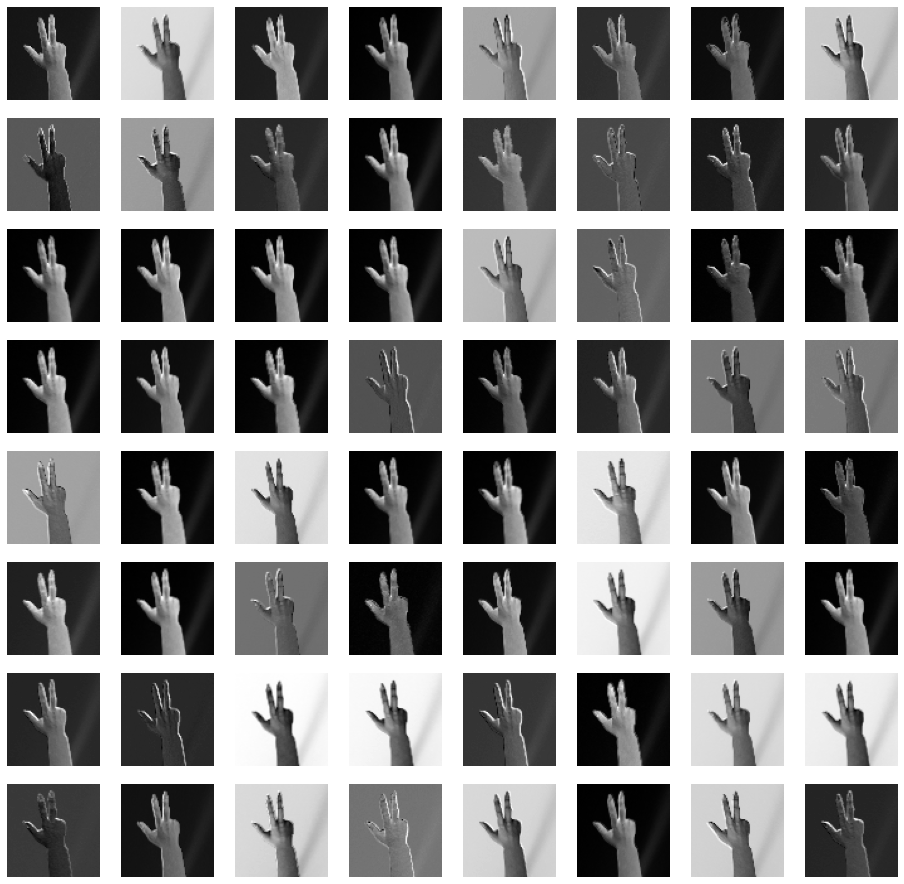

In [22]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16, 16)
for i in range(64):
  axes[i//8, i%8].imshow(MaxPooling2D(2, 2)(conv2d(pic))[1, :, :, i], cmap='gray')
  axes[i//8, i%8].axis('off')

## 단계별 특성 추출 과정

In [23]:
conv1 = Conv2D(64, (3, 3), input_shape=(150, 150, 3))(pic)
max1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(64, (3, 3))(max1)
max2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, (3, 3))(max2)
max3 = MaxPooling2D(2, 2)(conv3)

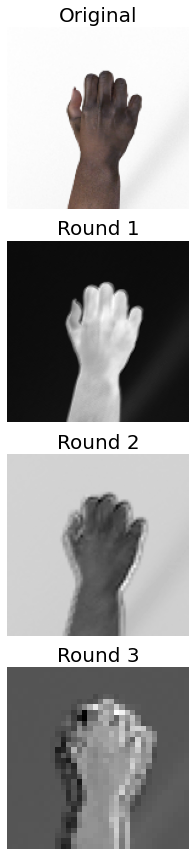

In [24]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6, 12)
axes[0].set_title('Original', fontsize=20)
axes[0].imshow(pic[0])
axes[0].axis('off')

axes[1].set_title('Round 1', fontsize=20)
axes[1].imshow(conv1[0, :,:, 0], cmap='gray')
axes[1].axis('off')

axes[2].set_title('Round 2', fontsize=20)
axes[2].imshow(conv2[0, :, :, 0], cmap='gray')
axes[2].axis('off')

axes[3].set_title('Round 3', fontsize=20)
axes[3].imshow(conv3[0, :, :, 0], cmap='gray')
axes[3].axis('off')
plt.tight_layout()
plt.show()

# 모델정의 (Sequential)

In [25]:
model = Sequential([
                    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    # 2D -> 1D
                    Flatten(),
                    # 과적합 방지
                    Dropout(0.5),
                    Dense(512, activation='relu'),
                    # Classification
                    Dense(3, activation='softmax')
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       1

# Compile


1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`설정
  * 출력층 activation이 `sigmoid` 인 경우: `binary_crossentropy`
  * 출력층 activation이 `softmax` 인 경우: 
    * 원핫인코딩(O): `categorical_crossentropy`
    * 원핫인코딩(X): `sparse_categorical_crossentropy`)
3. 참고: `ImageDataGenerator`는 자동으로 Label을 **원핫인코딩(one-hot encoding)** 해줍니다.
4. `metrics`를 'acc' 혹은 'accuracy'로 지정하면, 학습시 정확도를 모니터링 할 수 있습니다.

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [28]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# fit

In [29]:
epochs = 25

In [30]:
history = model.fit(training_generator,
                    validation_data = (validation_generator),
                    epochs= epochs,
                    # steps_per_epoch = len(training_generator),  버전오류로 실행이 안될때
                    # validation_steps = len(validation_generator),
                    callbacks=[checkpoint])

Epoch 1/25
16/16 [==============================] - 25s 1s/step - loss: 1.1776 - acc: 0.3462 - val_loss: 1.1008 - val_acc: 0.3452

Epoch 00001: val_loss improved from inf to 1.10077, saving model to my_checkpoint.ckpt
Epoch 2/25
16/16 [==============================] - 19s 1s/step - loss: 1.0713 - acc: 0.4306 - val_loss: 1.1477 - val_acc: 0.2996

Epoch 00002: val_loss did not improve from 1.10077
Epoch 3/25
16/16 [==============================] - 19s 1s/step - loss: 0.9957 - acc: 0.5193 - val_loss: 1.1152 - val_acc: 0.3452

Epoch 00003: val_loss did not improve from 1.10077
Epoch 4/25
16/16 [==============================] - 19s 1s/step - loss: 0.8657 - acc: 0.6116 - val_loss: 0.9468 - val_acc: 0.5635

Epoch 00004: val_loss improved from 1.10077 to 0.94685, saving model to my_checkpoint.ckpt
Epoch 5/25
16/16 [==============================] - 19s 1s/step - loss: 0.7226 - acc: 0.7098 - val_loss: 1.0558 - val_acc: 0.4127

Epoch 00005: val_loss did not improve from 0.94685
Epoch 6/25
16/

# Load Weights

In [31]:
model.load_weights(checkpoint_path)

# 시각화

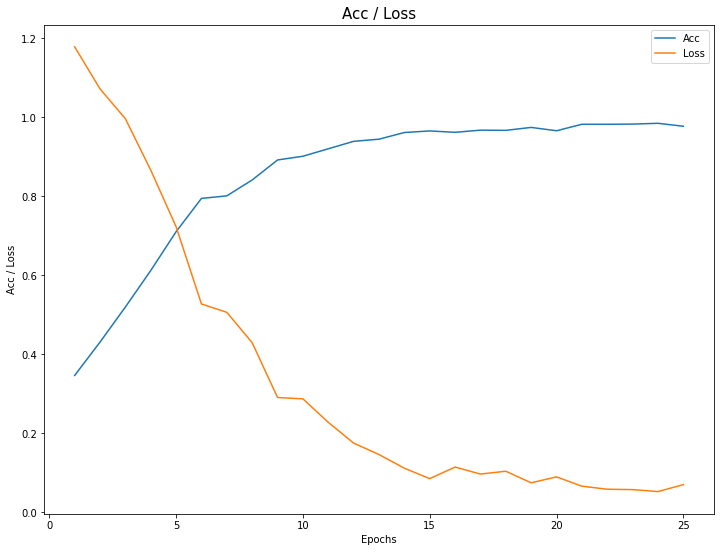

In [34]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.title('Acc / Loss', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Acc / Loss')
plt.legend(['Acc', 'Loss'], fontsize=10)
plt.show()